
Trong notebook này, chúng ta sẽ thử quy trình lập trình RNN với Keras để phân loại các câu văn bản.

I.   **Trước tiên**, chúng ta sẽ nhập các thư viện hữu ích.

II.   **Sau đó**, chúng ta sẽ load dữ liệu và tạo ma trận word embedding bằng Glove.

III.  **Chúng ta sẽ thử một mô hình RNN đơn giản** rồi đánh giá chất lượng của nó.

IV. Cuối cùng, chúng ta sẽ sử dụng các kỹ thuật để gia tăng độ chính xác của mô hình.

1. Thiết lập Fre GPU trong notebook này.

In [ ]:
!nvidia-smi

Sun Jan 26 03:21:58 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Gắn Google Drive cục bộ
2. Gắn Google vào Google Colab Driver.


In [ ]:
## VIẾT CODE cho task 2 ở đây:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# I. Nhập tất cả các thư viện hữu ích.

In [ ]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import tensorflow.keras
import datetime
from tensorflow.keras import backend as K
import tensorflow.keras.optimizers as Optimizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, load_model


from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.metrics import confusion_matrix as CM
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plot
import seaborn as sn

3. Copy tập dữ liệu từ Google Drive vào Colab

In [ ]:
## VIẾT CODE cho task 3 ở đây:
import zipfile

# Đường dẫn đến file ZIP
zip_path = "/content/drive/MyDrive/MLP306x_01-A_VN /ASM2/train.csv.zip"

# Thư mục đích để giải nén
extract_to = "train"

# Tạo thư mục đích nếu chưa tồn tại
os.makedirs(extract_to, exist_ok=True)

# Giải nén tệp ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("File đã được giải nén vào:", extract_to)


File đã được giải nén vào: train


# II. Load dữ liệu.

## Về tập dữ liệu.
Câu hỏi không hợp lệ là những câu hỏi nhằm đưa ra một tuyên bố thay vì tìm kiếm những câu trả lời hữu ích. Một số đặc điểm cho thấy câu hỏi không hợp lệ gồm:

* Có giọng điệu không trung lập.
* Có tính chê bai hoặc kích động.
* Không có căn cứ thực tế.
* Sử dụng nội dung khiêu dâm (loạn luân, thú tính, ấu dâm) để gây sốc, không phải để tìm kiếm câu trả lời xác thực.

Dữ liệu bao gồm câu hỏi đã đề ra và liệu nó có được xác định là không hợp lệ hay không (target = 1).

4. Load tập dữ liệu.
* Load dữ liệu từ file CSV.
* Xóa tất cả các hàng có giá trị NA.
* Chia dữ liệu thành 3 tập: Tập huấn luyện, tập kiểm định và tập kiểm tra (0.9/0.05/0.05, random_seed = 9) với cùng một tỷ lệ số dữ liệu giữa mỗi lớp.
* In ra mô tả của tập dữ liệu này.




In [ ]:
from sklearn.model_selection import train_test_split
def load_data(data_link):
    '''
    input: data link.
    output:
        train_set, validation_set và test_set(0.95/0.05/0.05) mà không có các giá trị NA.
    '''
    ## VIẾT CODE cho task 4 ở đây:
    data = pd.read_csv(data_link)
    data = data.dropna()
    # Chia tập huấn luyện (90%) và phần còn lại (10%)
    train, temp_data = train_test_split(
      data,
      test_size=0.1,
      stratify= data['target'],  # Thay 'label' bằng cột chứa nhãn
      random_state=9
    )

    # Chia tiếp phần còn lại (10%) thành tập kiểm định (5%) và kiểm tra (5%)
    validation, test = train_test_split(
      temp_data,
      test_size=0.5,
      stratify=temp_data['target'],  # Thay 'label' bằng cột chứa nhãn
      random_state=9
    )


    return train, validation, test

train_set, validation_set, test_set = load_data('/content/train/train.csv')
print(train_set.describe())
print(validation_set.describe())
print(test_set.describe())

             target
count  1.175509e+06
mean   6.187022e-02
std    2.409198e-01
min    0.000000e+00
25%    0.000000e+00
50%    0.000000e+00
75%    0.000000e+00
max    1.000000e+00
             target
count  65306.000000
mean       0.061863
std        0.240908
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
             target
count  65307.000000
mean       0.061877
std        0.240934
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000


In [ ]:
train_set.head()

,qid,question_text,target
131847,19cc4d927b245af126e3,How can each member of couple build up their c...,0
816407,9ff864c51e7bc8e5de28,How is NASA benefitted by scientists?,0
151531,1da2ba044320ecc77c5e,Is it true that Drupada defeated Karna in a ma...,0
170562,2156a6578994e1580282,What effect would a Trump resignation have on ...,0
271736,3530e9f4c9d8c24a5ad7,What is it like during AIT like at Fort Gordon?,0


# Mã hóa dữ liệu văn bản.
Hãy khai báo một số tham số cơ bản trước:

In [ ]:
embed_size = 50 # mỗi vectơ từ lớn bao nhiêu
max_features = 20000 # cần sử dụng bao nhiêu từ duy nhất (tức là số hàng trong vectơ embedding)
max_len = 50 # sử dụng số từ tối đa trong câu hỏi


5. Mã hóa tập dữ liệu bằng Tokenizer và vectơ biểu diễn one-hot.
* Mã hóa văn bản (cột question_text) bằng cách chuyển từng question text thành danh sách chỉ mục từ bằng [Tokenizer](https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do) với **max_features** và tất cả các câu văn bản từ tập huấn luyện và tập kiểm định.
* Chuyển từng danh sách chỉ mục từ thành độ dài như nhau - **max_len** (có cắt tỉa hoặc đệm nếu cần) bằng cách sử dụng [pad_sequences](https://keras.io/preprocessing/sequence/).
* Mã hóa nhãn (cột nhãn) bằng cách sử dụng hàm [to_categorical](https://keras.io/utils/) trong Keras.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
num_classes = len(train_set['target'].unique())
num_classes

2

In [ ]:
def encoding_textdata(train_set, validation_set, test_set, max_features, max_len):
    '''
    Input:
    - Train/validation/test dataset.
    - max_features, max_len.
    Output:
    - X train/validation/test, y train/validation/test.
    - Tokenizer.
    '''
    # Dữ liệu văn bản
    train_texts = train_set['question_text'].values
    val_texts = validation_set['question_text'].values
    test_texts = test_set['question_text'].values

    # Nhãn
    y_tr = train_set['target'].values
    y_va = validation_set['target'].values
    y_te = test_set['target'].values
    # Khởi tạo Tokenizer
    tokenizer = Tokenizer(num_words=max_features)

    # Fit tokenizer trên toàn bộ tập huấn luyện + tập kiểm định
    tokenizer.fit_on_texts(np.concatenate((train_texts, val_texts), axis=0))
    # Token hóa dữ liệu
    train_sequences = tokenizer.texts_to_sequences(train_texts)
    validation_sequences = tokenizer.texts_to_sequences(val_texts)
    # Chuyển về độ dài như nhau
    X_tr = pad_sequences(train_sequences, maxlen=max_len)
    X_va = pad_sequences(validation_sequences, maxlen=max_len)
    X_te = pad_sequences(tokenizer.texts_to_sequences(test_texts), maxlen=max_len)
    # Mã hóa nhãn (One-hot encoding)
    y_tr = to_categorical(y_tr)
    y_va = to_categorical(y_va)

    return (X_tr, y_tr), (X_va, y_va), (X_te, y_te), tokenizer

(X_tr, y_tr), (X_va, y_va), (X_te, y_te), tokenizer = encoding_textdata(train_set, validation_set, test_set, max_features, max_len)

6. Tạo ma trận word embedding.
* Đầu tiên, hãy viết một hàm để load [GloVe dictionary.](https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db)
* Sau đó, tạo ma trận word embedding bằng GloVe dictionary với các tham số sau:
    - Shape của ma trận word embedding: (Number of word, embed_size).
    - Embed size: 50.
    - Number of words: Tối thiểu của (max_features, len(word_index)), trong khi word_index là dictionary của từ chứa trong tokenizer.
    - Nếu một từ xuất hiện trong GloVe dictionary, chúng ta nên lấy giá trị khởi tạo của nó như trong GloVe dictionary. Nếu không, hãy lấy một giá trị ngẫu nhiên bình thường với mean và std làm mean và std của giá trị GloVe dictionary.
    



In [ ]:
# Đường dẫn đến file ZIP
zip_path = "/content/drive/MyDrive/MLP306x_01-A_VN /ASM2/glove.6B.50d.txt.zip"

# Thư mục đích để giải nén
extract_to = "glove"

# Tạo thư mục đích nếu chưa tồn tại
os.makedirs(extract_to, exist_ok=True)

# Giải nén tệp ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("File đã được giải nén vào:", extract_to)

File đã được giải nén vào: glove


In [ ]:
def get_GloVe_dict(GloVe_link):
    '''
    input: GloVe link.
    output: GloVe dictionary.
    '''
    ## VIẾT CODE cho task 6 ở đây:
    # Tạo dictionary GloVe
    embeddings_index = {}

    # Mở file GloVe và đọc từng dòng
    with open(GloVe_link, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]  # Từ là phần đầu tiên
            coefs = np.asarray(values[1:], dtype='float32')  # Các vector từ còn lại
            embeddings_index[word] = coefs  # Lưu từ và vector vào dictionary

    return embeddings_index
GloVe_link = '/content/glove/glove.6B.50d.txt'
GloVe_dict = get_GloVe_dict(GloVe_link)

In [ ]:
def create_embedding_matrix(GloVe_dict, tokenizer, max_features):
    '''
    input: GloVe dictionaray, tokenizer từ tập huấn luyện và tập kiểm định, số lượng đặc trưng tối đa.
    output: Word embedding matrix.
    '''

    ## VIẾT CODE cho task 6 ở đây:
     # Lấy chiều dài vector GloVe (giả sử tất cả các vector GloVe có cùng chiều dài)
    embedding_dim = len(next(iter(GloVe_dict.values())))  # Lấy chiều dài vector từ GloVe

    # Khởi tạo ma trận embedding với kích thước (max_features, embedding_dim)
    embedding_matrix = np.zeros((max_features, embedding_dim))

    # Lấy từ điển từ tokenizer
    word_index = tokenizer.word_index

    # Duyệt qua tất cả các từ trong tokenizer (từ điển của tập huấn luyện)
    for word, i in word_index.items():
        # Chỉ lấy các từ có trong từ điển và có chỉ mục nhỏ hơn max_features
        if i < max_features:
            # Nếu từ trong tokenizer có trong GloVe dictionary, sử dụng vector GloVe cho từ đó
            if word in GloVe_dict:
                embedding_matrix[i] = GloVe_dict[word]
            else:
                # Nếu từ không có trong GloVe, sử dụng vector không (zero vector)
                embedding_matrix[i] = np.zeros(embedding_dim)

    return embedding_matrix

embedding_matrix = create_embedding_matrix(GloVe_dict, tokenizer, max_features)

# III. Lập mô hình
Chúng ta cần hoàn thành một số bước:

Xây dựng mô hình.

Biên dịch mô hình.

Huấn luyện/khớp dữ liệu với mô hình.

Đánh giá mô hình trên tập kiểm tra.

## Xây dựng mô hình
7. Chúng ta có thể xây dựng một mô hình dễ dàng gồm các layer khác nhau như:
* Layer [Embedding](https://keras.io/layers/embeddings/) với max_features, embed_size và embedding_matrix.
* [Bidirectional LSTM layer](https://keras.io/examples/nlp/bidirectional_lstm_imdb/?fbclid=IwAR3fEd6aWyeIDEhZSspjtCRiP0c0Jnz5-XdnUHQYwX8Tp8k9Ni4I8Q5tP9o) với số lượng trạng thái ẩn = 50, dropout_rate = 0.1 và recurrent_dropout_rate = 0.1.
* GlobalMaxPool1D.
* Dense với số nút = 50, activation = 'relu'.
* Dropout với rate = 0.1.
* Final dense với số nút = số class, activation = 'sigmoid'.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPooling1D, Dense, Dropout
def create_model(max_len, max_features, embed_size):
    '''
    input: max_len, max_features, embed_size
    output: model.
    '''
    model = Sequential([
        # Thêm lớp Input
        Input(shape=(max_len,)),

        # Lớp Embedding với embedding_matrix
        Embedding(input_dim=max_features,
                  output_dim=embed_size,
                  weights=[embedding_matrix],
                  input_length=max_len,
                  trainable=False),

        # Lớp Bidirectional LSTM
        Bidirectional(LSTM(50, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)),

        # Lớp GlobalMaxPooling1D
        GlobalMaxPooling1D(),

        # Lớp Dense với 50 nút và activation 'relu'
        Dense(50, activation='relu'),

        # Lớp Dropout với tỷ lệ dropout 0.1
        Dropout(0.1),

        # Lớp Dense cuối cùng với số nút bằng num_classes
        Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')
    ])

    return model




model = create_model(max_len, max_features, embed_size)



8. Biên dịch mô hình và thiết lập callback. Sau đó in ra model summary.
* [Biên dịch](https://keras.io/models/model/#compile) mô hình với Adam Optimizer, lr = 1e-2, loss phù hợp cho bài toán phân loại nhị phân và ["F1-score"](https://github.com/tensorflow/addons/issues/825) là phép đo.
* In ra model summary.

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.optimizers import Adam
from keras.saving import register_keras_serializable

@register_keras_serializable(package="Custom")

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = self.add_weight(name="precision", initializer="zeros")
        self.recall = self.add_weight(name="recall", initializer="zeros")
        self.f1_score = self.add_weight(name="f1_score", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Làm tròn dự đoán để có 0 hoặc 1
        y_pred = tf.round(y_pred)

        # Tính Precision và Recall
        true_positives = tf.reduce_sum(y_true * y_pred)
        predicted_positives = tf.reduce_sum(y_pred)
        possible_positives = tf.reduce_sum(y_true)

        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        recall = true_positives / (possible_positives + tf.keras.backend.epsilon())

        # Tính F1-score từ Precision và Recall
        f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

        # Cập nhật các giá trị
        self.precision.assign(precision)
        self.recall.assign(recall)
        self.f1_score.assign(f1_score)

    def result(self):
        # Trả về giá trị F1-score tính được
        return self.f1_score

    def reset_state(self):
        # Đặt lại trạng thái
        self.precision.assign(0.0)
        self.recall.assign(0.0)
        self.f1_score.assign(0.0)
def optimize(model):
    '''
    Input:
        Mô hình.
    Return:
        Mô hình đã biên dịch.
    '''
    model.compile(optimizer=Adam(learning_rate=1e-2),
                  loss='categorical_crossentropy',
                  metrics=[F1Score()])
    return model

model = optimize(model)
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 50, 50)              │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 100)             │          40,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ (None, 100)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,045,552 (3.99 MB)

 Trainable params: 45,552 (177.94 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

None


9. Thiết lập callback.
* Tạo [tensorboard callback](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) để lưu logs.
* Tạo [checkpoint callback](https://machinelearningmastery.com/check-point-deep-learning-models-keras/) để lưu checkpoint với độ chính xác tốt nhất sau mỗi epoch.
* Tạo [ReduceLROnPlateau](https://keras.io/callbacks/#reducelronplateau) callback với factor=0.3, patience=1 và "Validation F1-score" monitor.
* Tạo [early stopping callback](https://keras.io/callbacks/#earlystopping) với patience=7, mode = 'max' và "Validation F1-score" monitor.



In [ ]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

def callback_model(checkpoint_name, logs_name):
    '''
    Input:
        checkpoint_name: Tên file checkpoint lưu mô hình tốt nhất.
        logs_name: Tên thư mục để lưu logs của TensorBoard.
    Return:
        callbacks_list: Danh sách các callback để sử dụng trong quá trình huấn luyện.
    '''
    # TensorBoard callback
    tensorboard_callback = TensorBoard(log_dir=logs_name, histogram_freq=1)

    # ModelCheckpoint callback - Lưu mô hình tốt nhất dựa trên val_f1_score
    checkpoint_callback = ModelCheckpoint(
        checkpoint_name,
        monitor='val_f1_score',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    # ReduceLROnPlateau callback - Giảm learning rate nếu F1-score không cải thiện
    reduce_lr_callback = ReduceLROnPlateau(
        monitor='val_f1_score',
        factor=0.3,
        patience=1,
        verbose=1,
        mode='max'
    )

    # EarlyStopping callback - Dừng huấn luyện nếu F1-score không cải thiện trong 7 epoch
    early_stopping_callback = EarlyStopping(
        monitor='val_f1_score',
        patience=7,
        mode='max',
        verbose=1
    )

    # Tạo danh sách các callback
    callbacks_list = [
        tensorboard_callback,
        checkpoint_callback,
        reduce_lr_callback,
        early_stopping_callback
    ]

    return callbacks_list

# Ví dụ sử dụng callback_model
checkpoint_name = 'model.keras'
logs_name = 'training_logs'
callbacks_list = callback_model(checkpoint_name, logs_name)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50, 50)              │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 100)             │          40,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 100)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,045,552 (3.99 MB)

 Trainable params: 45,552 (177.94 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

10.  Huấn luyện mô hình.

* Huấn luyện mô hình với 20 epoch với batch_size = 4096.
* Trả về mô hình có trọng số checkpoint tốt nhất.

*Gợi ý*: Trước tiên hãy khớp mô hình, sau đó reload mô hình (hàm load_model) với trọng số checkpoint tốt nhất.

In [ ]:
def train_model(model, callbacks_list):
    '''
    Input:
        Mô hình và callback list,
    Return:
        Mô hình với trọng số checkpoint tốt nhất.
    '''
    ## VIẾT CODE cho task 10 ở đây:
    history = model.fit(
    X_tr, y_tr,  # Dữ liệu huấn luyện
    epochs=20,  # Số epoch
    batch_size=4096,  # Kích thước batch
    validation_data=(X_va, y_va),  # Dữ liệu validation
    callbacks=callbacks_list  # Danh sách các callback
)
    # Sau khi huấn luyện xong, nạp lại mô hình với trọng số tốt nhất từ checkpoint
    model = load_model(checkpoint_name)
    return model

model = train_model(model, callbacks_list)


Epoch 1/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - f1_score: 0.9568 - loss: 0.1110
Epoch 1: val_f1_score improved from -inf to 0.96017, saving model to model.keras
287/287 ━━━━━━━━━━━━━━━━━━━━ 56s 177ms/step - f1_score: 0.9568 - loss: 0.1110 - val_f1_score: 0.9602 - val_loss: 0.1082 - learning_rate: 0.0100
Epoch 2/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - f1_score: 0.9572 - loss: 0.1087
Epoch 2: val_f1_score did not improve from 0.96017

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
287/287 ━━━━━━━━━━━━━━━━━━━━ 81s 173ms/step - f1_score: 0.9572 - loss: 0.1087 - val_f1_score: 0.9602 - val_loss: 0.1088 - learning_rate: 0.0100
Epoch 3/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - f1_score: 0.9580 - loss: 0.1064
Epoch 3: val_f1_score improved from 0.96017 to 0.96327, saving model to model.keras
287/287 ━━━━━━━━━━━━━━━━━━━━ 50s 174ms/step - f1_score: 0.9580 - loss: 0.1064 - val_f1_score: 0.9633 - val_loss: 0.1072 - learning_rate: 0.0030
Epoch 4/20


11. Hiển thị tensorboard trong notebook.

In [ ]:
## VIẾT CODE cho task 11 ở đây:
%load_ext tensorboard
%tensorboard --logdir /content/training_logs


12. Dự đoán trên tập kiểm tra.

* Hoàn thành hàm get_prediction_classes.
* In ra precision, recall và F1 score.

In [ ]:
def get_prediction_classes(model, X, y):
    ## VIẾT CODE cho task 12 ở đây:
    '''
    Input:
        Mô hình và tập dữ liệu dự đoán.
    Return:
        Prediction list và groundtrurth list với predicted classes.
    '''
    predictions = model.predict(X)
    predictions = np.argmax(predictions, axis=1)
    groundtruths = y


    return predictions, groundtruths


test_predictions, test_groundtruths = get_prediction_classes(model,  X_te, y_te)
print(precision_score(test_predictions, test_groundtruths))
print(recall_score(test_predictions, test_groundtruths))
print(f1_score(test_predictions, test_groundtruths))

2041/2041 ━━━━━━━━━━━━━━━━━━━━ 88s 43ms/step
0.5854986389507547
0.6920152091254753
0.6343163538873995


Điểm f1_score: 0.6343163538873995

13. Thực hiện kết quả dự đoán trên tập kiểm tra bằng cách sử dụng ma trận nhầm lẫn. Hãy nhớ hiển thị tên lớp trong ma trận nhầm lẫn.

<Figure size 800x600 with 0 Axes>

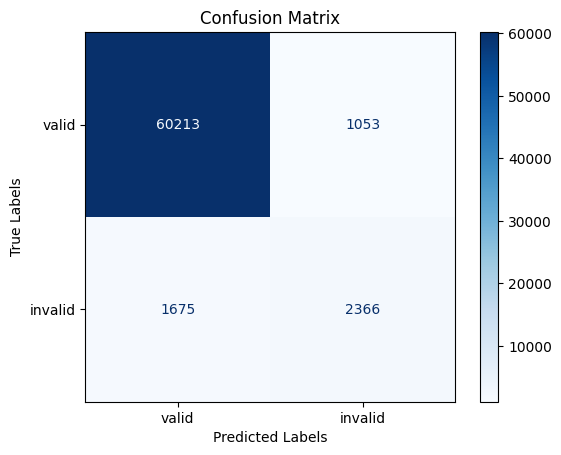

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(predictions, groundtruth, class_names):
    ## VIẾT CODE cho task 13 ở đây:
    # Calculate the confusion matrix
    cm = confusion_matrix(groundtruth, predictions)

    # Create a confusion matrix plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Customize the plot
    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.grid(False)  # Turn off the grid for better visualization
    plt.show()


class_names = ['valid', 'invalid']
plot_confusion_matrix(test_predictions, test_groundtruths, class_names)

14. Tinh chỉnh mô hình - tinh chỉnh mô hình



1. Thử thay thế bằng mô đun Attention

In [ ]:
## VIẾT CODE cho task 14 ở đây:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Bidirectional, LSTM, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, LayerNormalization, Dropout, Flatten
def create_model(max_len, max_features, embed_size):
    '''
    input: max_len, max_features, embed_size
    output: model.
    '''
    # Input layer
    inputs = Input(shape=(max_len,))

    # Embedding layer
    embeddings = Embedding(input_dim=max_features,
                           output_dim=embed_size,
                           weights=[embedding_matrix],
                           input_length=max_len,
                           trainable=False)(inputs)

    # MultiHeadAttention layer - using the same embeddings for query, key, and value
    attention_output = MultiHeadAttention(num_heads=8, key_dim=embed_size)(embeddings, embeddings, embeddings)
    #                                       query          key        value

    # Layer Normalization
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

    # GlobalMaxPooling1D
    pooled_output = GlobalMaxPooling1D()(attention_output)  # Apply GlobalMaxPooling1D to attention output

    # Dense layers
    dense_output = Dense(50, activation='relu')(pooled_output)
    dense_output = Dropout(0.1)(dense_output)
    outputs = Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')(dense_output)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)


    return model




model = create_model(max_len, max_features, embed_size)

In [ ]:
model = optimize(model)
print(model.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 50, 50)         │      1,000,000 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_2    │ (None, 50, 50)         │         81,250 │ embedding_3[0][0],     │
│ (MultiHeadAttention)      │                        │                │ embedding_3[0][0],     │
│                           │                        │                │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 50, 50)         │            100 │ multi_head_attention_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_3    │ (None, 50)             │              0 │ layer_normalization_2… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 50)             │          2,550 │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 50)             │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 2)              │            102 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,084,002 (4.14 MB)

 Trainable params: 84,002 (328.13 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

None


In [ ]:
model = train_model(model, callbacks_list)

Epoch 1/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - f1_score: 0.9451 - loss: 0.1912
Epoch 1: val_f1_score improved from -inf to 0.95447, saving model to model.keras
287/287 ━━━━━━━━━━━━━━━━━━━━ 59s 167ms/step - f1_score: 0.9451 - loss: 0.1911 - val_f1_score: 0.9545 - val_loss: 0.1254 - learning_rate: 0.0100
Epoch 2/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - f1_score: 0.9524 - loss: 0.1243
Epoch 2: val_f1_score did not improve from 0.95447

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
287/287 ━━━━━━━━━━━━━━━━━━━━ 63s 130ms/step - f1_score: 0.9524 - loss: 0.1243 - val_f1_score: 0.9532 - val_loss: 0.1207 - learning_rate: 0.0100
Epoch 3/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - f1_score: 0.9547 - loss: 0.1182
Epoch 3: val_f1_score improved from 0.95447 to 0.95603, saving model to model.keras
287/287 ━━━━━━━━━━━━━━━━━━━━ 36s 126ms/step - f1_score: 0.9547 - loss: 0.1182 - val_f1_score: 0.9560 - val_loss: 0.1172 - learning_rate: 0.0030
Epoch 4/20


In [ ]:
def get_prediction_classes(model, X, y):
    ## VIẾT CODE cho task 12 ở đây:
    '''
    Input:
        Mô hình và tập dữ liệu dự đoán.
    Return:
        Prediction list và groundtrurth list với predicted classes.
    '''
    predictions = model.predict(X)
    predictions = np.argmax(predictions, axis=1)
    groundtruths = y


    return predictions, groundtruths


test_predictions, test_groundtruths = get_prediction_classes(model,  X_te, y_te)
print(precision_score(test_predictions, test_groundtruths))
print(recall_score(test_predictions, test_groundtruths))
print(f1_score(test_predictions, test_groundtruths))

2041/2041 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
0.5226429101707498
0.6901960784313725
0.5948457963667089


Chất lượng không cải thiện

2. Sử dụng transformer